In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json
from bibliometric_sec2prim import read_config_file
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
import requests
from datetime import datetime
from tqdm import tqdm
import time

In [2]:
CONFIG = read_config_file('config.yml', 'hgnc')
url_genenames = 'https://rest.genenames.org/fetch/symbol/{}'
date_format = "%Y-%m-%dT%H:%M:%SZ"

# Literature usage of primary and secondary HGNC symbols

This notebook analyzes the data obtained from [`bibliometric_sec2prim.py`](bibliometric_sec2prim.py). The goal of the analyses is to get a metric of the rate of overall of _primary symbols_ (the currently approved gene symbols) as opposed to _secondary symbols_ (previous symbols no longer approved by the HGNC). The results of the analyses highlight the need to account for these _deprecated_ gene names for genes when performing data integration, especially from data sources dating from before the `sec2pri` index reached its apparent plateau after 2015.

## 1. Importing data

The data can be obtained by running thr [bibliometric sec2prim](bibliometric_sec2prim.py) Python script. This script searches and retrieves the necessary data from the Europe PMC database using its [Articles RESTful Web Service `/search` module](https://europepmc.org/RestfulWebService#!/Europe32PMC32Articles32RESTful32API/search):
```Python
base_url = "https://www.ebi.ac.uk/europepmc/webservices/rest/search?query=ABSTRACT:\" {} \"&resultType=core&cursorMark={}&pageSize={}&format={}"
```

This allows to search for occurences of a given symbol (primary or secondary) on all available abstracts and retrieves the `journal_title`, `pubYear`,	and `pmid` for positive findings. Then, each secondary symbol result is linked back to its corresponding primary symbol.

First we import the HGNC mappings table. It consists of the following columns:
- `primaryID`: the current HGNC identifier for a gene.
- `primarySymbol`: the current HGNC symbol for a gene.
- `secondaryID`: the withdrawn HGNC identifiers for a gene.
- `secondarySymbol`: the withdrawn HGNC symbol for a gene.
- `predicateID`: the proposed mapping type between a primary and secondary symbol and ID pair.
- `source`: the source for the primary and secondary symbol and ID pair.


In [3]:
hgncs = pd.read_csv(CONFIG['hgnc']['path'], sep='\t')
hgncs.sample(5)

,primaryID,primarySymbol,secondaryID,secondarySymbol,predicateID,mapping_cardinality_sec2pri,comment,source
2655,HGNC:10495,S100A5,HGNC:10501,S100D,IAO:0100001,1:1,ID (subject) is replaced.,https://ftp.ebi.ac.uk/pub/databases/genenames/...
4337,Entry Withdrawn,Entry Withdrawn,HGNC:31847,LINC00108,oboInOwl:consider,1:0,ID (subject) withdrawn/deprecated.,https://ftp.ebi.ac.uk/pub/databases/genenames/...
4003,HGNC:51690,SEPTIN14P6,HGNC:21112,LINC00266-3,IAO:0100001,1:1,ID (subject) is replaced.,https://ftp.ebi.ac.uk/pub/databases/genenames/...
2233,HGNC:10985,SLC25A15,HGNC:8500,ORNT1,IAO:0100001,n:1,This ID (subject) and other ID(s) are merged i...,https://ftp.ebi.ac.uk/pub/databases/genenames/...
3798,HGNC:18636,RGSL1,HGNC:18635,RGSL2,IAO:0100001,1:1,ID (subject) is replaced.,https://ftp.ebi.ac.uk/pub/databases/genenames/...


Now we import the _primary symbol overall_ data obtained from `bibliometric_sec2prim.py` into a pandas DataFrame `overall_df`:

In [4]:
def generate_overall_data(df, json_file):
    seen_primaries_years = {}
    try:
        # Read the JSON file
        with open(json_file, 'r') as json_data:
            json_content = json.load(json_data)['result']

        # Create a DataFrame for primary and secondary symbols
        symbol_columns = ['primarySymbol', 'secondarySymbol', 'mapping_cardinality_sec2pri']
        primary_df = df[symbol_columns].drop_duplicates()
        secondary_df = df[symbol_columns].drop_duplicates()

        # Initialize a list to store overall data
        overall_data = []

        # Process firstColumn_alt and secondColumn_alt data
        length = len(json_content.get('firstColumn_alt', [])) + len(json_content.get('firstColumn_alt', []))
        i = -1
        for alt_data, symbol_type in [(json_content.get('firstColumn_alt', []), 'primary'), (json_content.get('secondColumn_alt', []), 'secondary')]:
            
            for entry in alt_data:
                symbol, article_data = entry.popitem()
                symbol_df = primary_df if symbol_type == 'primary' else secondary_df
                symbol_row = symbol_df[symbol_df[symbol_type + 'Symbol'] == symbol]
                if not symbol_row.empty:
                    symbol_row = symbol_row.iloc[0]
                    for article in article_data.values():
                        accession = ""
                        primary_symbol = symbol_row['primarySymbol'] if symbol_type == 'secondary' else symbol
                        secondary_symbol = symbol if symbol_type == 'secondary' else symbol_row['secondarySymbol']
                        journal_title = article.get('journalInfo.journal.title', 'NA')
                        pubYear = article.get('pubYear', 'NA')
                        cardinality = symbol_row['mapping_cardinality_sec2pri']
                        pmid = article.get('pmid', 'NA')
                        if primary_symbol not in seen_primaries_years.keys():
                            # Look for symbol change date using the HGNC API
                            url_symbol = url_genenames.format(symbol)
                            r = requests.get(url_symbol, headers=   {'Accept':'application/json'})
                            try:
                                accession = r.json()['response']['docs'][0] ['hgnc_id']
                                # Check that this is the same accession
                                if secondary_symbol == hgncs[hgncs['primaryID'] ==  accession]['secondarySymbol'].values[0]: 
                                    try:
                                        date = r.json()['response']['docs'][0] ['date_symbol_changed']
                                        date_object = datetime.strptime(date, date_format)
                                        year_change = date_object.year
                                    except Exception:
                                        year_change = np.nan
                            except:
                                year_change = np.nan
                            seen_primaries_years[primary_symbol] = year_change
                        else:
                            year_change = seen_primaries_years[primary_symbol]
                        i+=1
                        # Check for 'NA' values and skip the loop iteration if any is found
                        if 'NA' in [primary_symbol, secondary_symbol, journal_title, pubYear, cardinality, pmid]:
                            continue
                        
                        
                        overall_data.append({
                            'primarySymbol': primary_symbol,
                            'secondarySymbol': secondary_symbol,
                            'journal_title': journal_title,
                            'pubYear': pubYear,
                            'mapping_cardinality_sec2pri': cardinality,
                            'symbol_type': symbol_type,
                            'pmid': pmid,
                            'year_change':year_change
                        })
                        if year_change != np.nan:
                            print(f'pmid # {i}: {pmid}, primary: {primary_symbol} --({year_change})--> secondary: {secondary_symbol}, accession: {accession}', end='\r', flush=True)
                        else:
                            print(f'pmid # {i}: {pmid}:, {primary_symbol}, no year_change available, {secondary_symbol}, accession: {accession}', end='\r')

        # Create a DataFrame from the overall_data list
        overall_df = pd.DataFrame(overall_data)
        overall_df = overall_df[overall_df['pubYear'] != np.nan]
        overall_df = overall_df[overall_df['pubYear'] != 'NA']
        overall_df['pubYear'] = pd.to_numeric(overall_df['pubYear'])
        overall_df['symbol_type'] = overall_df['symbol_type'].astype('category')
        overall_df['symbol_code'] = ['0' if i=='primary' else '1' for i in overall_df['symbol_type']]
        overall_df['symbol'] = np.where(overall_df['symbol_type'] == 'primary', overall_df['primarySymbol'], overall_df['secondarySymbol'])
        overall_df = overall_df[overall_df['primarySymbol'] != 'Entry Withdrawn']
        return overall_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of errors


`overall_df` contains the following columns:
- `primarySymbol`, `secondarySymbol`, `mapping_cardinality_sec2pri`, etc. as defined before
- `pmid`: each distinct PubMed identifier for journal articles for which the abstract contains a hit for the symbol under `symbol`
- `symbol_code`: 0 for _primary_ and 1 for _secondary_
- `year_change`: the year the primary symbol was approved and adopted, retrieved using the `url_genenames` ('https://rest.genenames.org/fetch/symbol/{}')

In [5]:
#overall_df = generate_overall_data(hgncs, 'result/hgnc_with_journal.json') # Skip: importing the result in a csv
overall_df = pd.read_csv('overall_df.csv')
overall_df.sample(5)

,primarySymbol,secondarySymbol,journal_title,pubYear,mapping_cardinality_sec2pri,symbol_type,pmid,year_change,symbol_code,symbol
76787,TNFRSF1A,TNFR1,PloS one,2018,1:1,primary,29420562,NaN,0,TNFRSF1A
134050,MPZ,CMT1B,Neuromuscular disorders : NMD,2008,1:1,primary,17825553,NaN,0,MPZ
79535,UBA1,A1S9T,Intractable & rare diseases research,2023,n:1,primary,37662628,2007.0,0,UBA1
174549,FABP3,MDGI,Pharmacology research & perspectives,2014,n:1,primary,25505575,NaN,0,FABP3
347550,NR2E1,TLX,Anticancer research,2022,1:1,secondary,36192000,NaN,1,TLX


In [6]:
overall_df.to_csv('overall_df.csv', index=False)
overall_df.describe()

,pubYear,pmid,year_change,symbol_code
count,454990.000000,4.549900e+05,50840.000000,454990.000000
mean,2013.366667,2.524937e+07,2006.874489,0.281367
std,8.337542,8.730154e+06,4.105184,0.449666
min,1913.000000,1.320000e+03,2001.000000,0.000000
25%,2009.000000,1.922504e+07,2004.000000,0.000000
50%,2015.000000,2.650149e+07,2006.000000,0.000000
75%,2020.000000,3.260668e+07,2008.000000,1.000000
max,2024.000000,3.775662e+07,2022.000000,1.000000


In [7]:
overall_df.sample(5)

,primarySymbol,secondarySymbol,journal_title,pubYear,mapping_cardinality_sec2pri,symbol_type,pmid,year_change,symbol_code,symbol
334754,KCNH2,LQT2,Neurology,2009,1:1,secondary,19038855,NaN,1,LQT2
177789,PDE4C,DPDE1,Electrophoresis,2021,1:1,primary,33629357,NaN,0,PDE4C
153822,MAP2K1,PRKMK1,eLife,2022,1:1,primary,35975983,NaN,0,MAP2K1
414172,EPHB4,HTK,Cryobiology,2015,1:1,secondary,25555715,NaN,1,HTK
147395,FTH1,FTHL6,Frontiers in pharmacology,2021,1:1,primary,34925024,NaN,0,FTH1


However, this data set describes `primary` and `secondary` symbols in terms of the HGNC recommendations as of 2023. To determine whether a symbol found in literature was primary or secondary **at the time of publishing**, it is necessary to determine the year in which it became primary. Any `secondary` symbol found in literaure dating to before its `year_change` should be considered a `primary` symbol.

How many HGNC symbols have data for the year they were changed?

In [8]:
symbols = overall_df[['primarySymbol', 'year_change']].dropna().drop_duplicates()
total_symbols = list(set(overall_df['primarySymbol'].tolist()))
print(f'{len(symbols)} symbols out of {len(total_symbols)} with year of change field ({round(len(symbols)/len(total_symbols), 2)*100}%)')
symbols.describe()

426 symbols out of 2346 with year of change field (18.0%)


,year_change
count,426.000000
mean,2008.223005
std,4.658153
min,2001.000000
25%,2005.000000
50%,2007.000000
75%,2011.000000
max,2022.000000


In [9]:
cardinality_1to1 = overall_df[overall_df['mapping_cardinality_sec2pri']!='n:1']
cardinality_1to1 = cardinality_1to1.dropna(subset=['year_change'])
print(cardinality_1to1.describe())
print(len(set(overall_df['primarySymbol'])) - len(set(cardinality_1to1['primarySymbol'])))

            pubYear          pmid   year_change   symbol_code
count  40659.000000  4.065900e+04  40659.000000  40659.000000
mean    2014.680833  2.667597e+07   2006.941981      0.144986
std        7.724541  8.197777e+06      4.090731      0.352091
min     1971.000000  5.940000e+03   2001.000000      0.000000
25%     2011.000000  2.170135e+07   2004.000000      0.000000
50%     2017.000000  2.826010e+07   2006.000000      0.000000
75%     2021.000000  3.338246e+07   2008.000000      0.000000
max     2024.000000  3.775656e+07   2022.000000      1.000000
1977


There are 1977 less entries than in the `overall_df` in the 1:1 cardinality, `year_change` including data frame, `cardinality_1to1`.

In [10]:
len(set(overall_df['primarySymbol']))

2346

And a total of 2346 entries. 


If a now-secondary symbol ina  1:1 cardinality with its primary is found in an article published before `year_change` it needs to be considered a primary symbol.

In [11]:
changes = 0
for i, row in cardinality_1to1.iterrows():
    if row['pubYear'] < row['year_change']:
        cardinality_1to1.loc[i, 'category'] = 'primary'
        changes +=1 
print('{} entries describing a hit for a now-secondary symbol have been annotated as containing a `primary` symbol  because it was primary at the time of publishing'.format(changes))

6180 entries describing a hit for a now-secondary symbol have been annotated as containing a `primary` symbol  because it was primary at the time of publishing


In [30]:
cardinality_1to1.describe()

,pubYear,pmid,year_change,symbol_code
count,40659.000000,4.065900e+04,40659.000000,40659.000000
mean,2014.680833,2.667597e+07,2006.941981,0.144986
std,7.724541,8.197777e+06,4.090731,0.352091
min,1971.000000,5.940000e+03,2001.000000,0.000000
25%,2011.000000,2.170135e+07,2004.000000,0.000000
50%,2017.000000,2.826010e+07,2006.000000,0.000000
75%,2021.000000,3.338246e+07,2008.000000,0.000000
max,2024.000000,3.775656e+07,2022.000000,1.000000


## 2. Plot primary and secondary symbol usage throughout the years

### Overall
`overall_df` allows to plot the evolution of the usage of primary symbols vs secondary symbols. It is not possible to determine whether symbols were primary or secondary at the time of publishing for the cases for which cardinality is not 1 to 1, so the terms are divided into primary and secondary according to the HGNC recommendations as of 2023 and not at the time of publication for each hit.

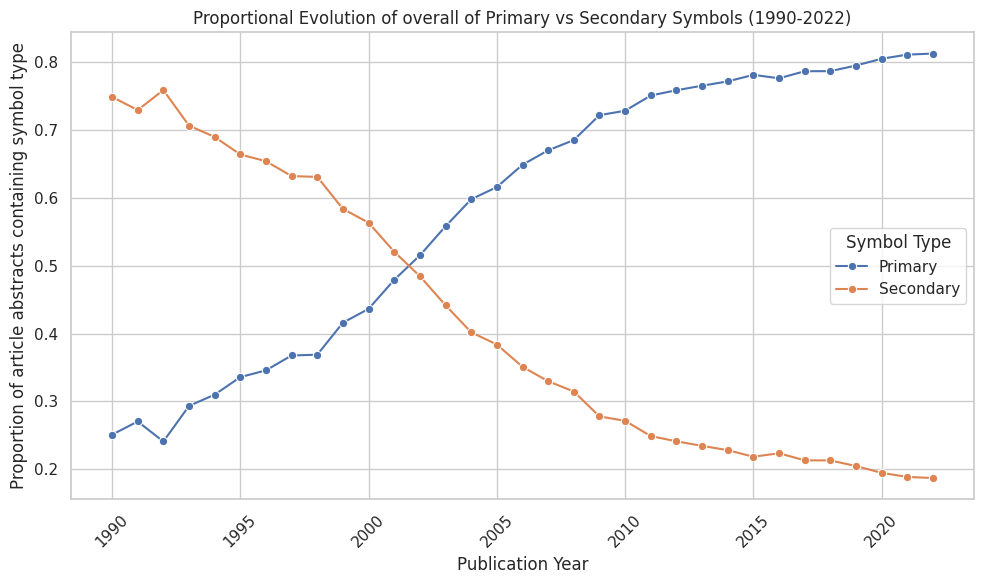

In [12]:
def plot_overall_evolution(overall_df, year_range=(2000, 2022), title = 'Proportional Evolution of overall of Primary vs Secondary Symbols ({}-{})'):
    try:

        # Filter by year range
        overall_df = overall_df[(overall_df['pubYear'] >= year_range[0]) & (overall_df['pubYear'] <= year_range[1])]

        # Create a count plot
        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")

        # Count the number of primary symbols for each year
        primary_counts = overall_df[overall_df['symbol_type'] == 'primary'].groupby('pubYear').size()

        # Count the number of secondary symbols for each year
        secondary_counts = overall_df[overall_df['symbol_type'] == 'secondary'].groupby('pubYear').size()

        primary_normalized = primary_counts / (primary_counts+secondary_counts)
        secondary_normalized = secondary_counts / (primary_counts+secondary_counts)


        # Plot primary and secondary counts
        sns.lineplot(x=primary_normalized.index, y=primary_normalized.values, label='Primary', marker='o')
        sns.lineplot(x=secondary_normalized.index, y=secondary_normalized.values, label='Secondary', marker='o')

        plt.xlabel('Publication Year')
        plt.ylabel('Proportion of article abstracts containing symbol type')
        plt.title(title.format(year_range[0], year_range[1]))
        plt.legend(title='Symbol Type')
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Show the plot
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")
plot_overall_evolution(overall_df, (1990, 2022))

The primary symbol overall line shows a plateau after 2015 at around 80% of primary symbol usage versus 20% of secondary symbol usage. The issue with older publications using secondary symbols is apparent. 

Zooming into the most recent years:

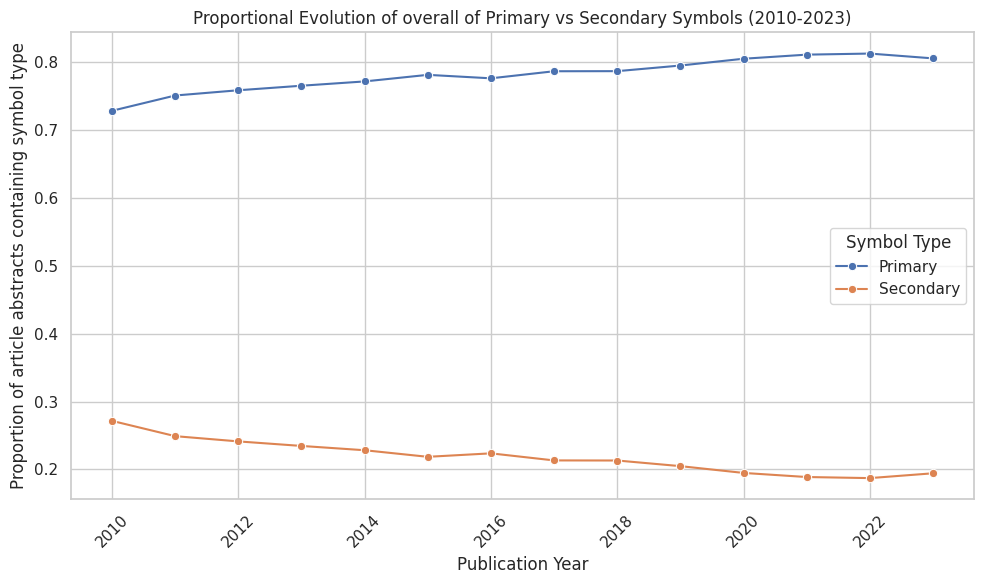

In [13]:
plot_overall_evolution(overall_df,(2010,2023))

The rate of overall primary symbol seems to have hit a plateau at around 80%.

## Subset for adoption after change for 1-to-1 cardinality symbols

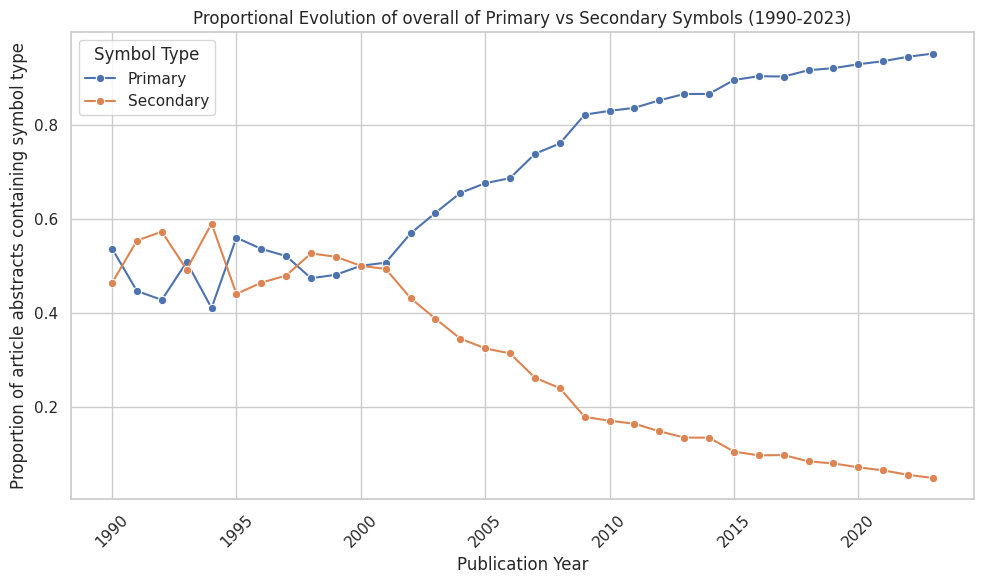

In [14]:
plot_overall_evolution(cardinality_1to1, (1990,2023))

## Further questions:
- Which are the best regarded journals in terms of HGNC usage?
- Some journals have guidance on symbol usage - does it have an effect?

## 2. Sec2Pri index

We calculate the sec2pri index for each gene, year and journal. The sec2pri index is defined as follows, with 
- p = number of instances of a publication containing a primary symbol in its abstract, and 
- s = number of publications using any of the secondary symbols associated to p in its abstract:

$$ sec2pri = {\sum s \over \sum s + p} $$

In [15]:
def sec2pri(df, aggregate_journal = True):
    primary_df = df[df['symbol_type'] == 'primary']
    secondary_df = df[df['symbol_type'] == 'secondary']
    grouped_primary = primary_df.groupby(['journal_title', 'pubYear', 'primarySymbol']).agg({'pmid': 'nunique'}).reset_index()
    grouped_secondary = secondary_df.groupby(['journal_title', 'pubYear', 'secondarySymbol', 'primarySymbol']).agg({'pmid': 'nunique'}).reset_index()
    merged = grouped_primary.merge(grouped_secondary, on=['journal_title', 'pubYear', 'primarySymbol'], how='left')
    merged.rename(columns={'pmid_x': 'pmid_primary', 'pmid_y': 'pmid_secondary'}, inplace=True)
    merged['pmid_secondary'] = merged['pmid_secondary'].fillna(0)
    merged['sec2pri'] = merged['pmid_secondary']/(merged['pmid_secondary']+merged['pmid_primary'])
    
    merged = merged.drop(['secondarySymbol'], axis=1).drop_duplicates()
    if aggregate_journal:
        merged = merged.groupby(['journal_title', 'pubYear']).agg(
            sec2pri_mean=('sec2pri', 'mean'),
            #sec2pri_var=('sec2pri', 'var')
).reset_index()
    #else:
        #merged['sec2pri_var'] = merged.groupby('primarySymbol')['sec2pri'].transform('var')
    return merged

In [16]:
sec2pri_all = sec2pri(overall_df, False)
sec2pri_all.sample(3)

,journal_title,pubYear,primarySymbol,pmid_primary,pmid_secondary,sec2pri
21487,Autonomic neuroscience : basic & clinical,2022,SCN8A,1,0.0,0.0
74543,Connective tissue research,2002,KLK4,1,0.0,0.0
220804,Oncotarget,2017,SDHC,1,0.0,0.0


In [17]:
sec2pri_all.describe()

,pubYear,pmid_primary,pmid_secondary,sec2pri
count,289575.000000,289575.000000,289575.000000,289575.000000
mean,2014.960256,1.126036,0.042583,0.017774
std,6.909237,0.516007,0.251058,0.093035
min,1940.000000,1.000000,0.000000,0.000000
25%,2011.000000,1.000000,0.000000,0.000000
50%,2017.000000,1.000000,0.000000,0.000000
75%,2021.000000,1.000000,0.000000,0.000000
max,2024.000000,40.000000,17.000000,0.944444


### 2.1.    Mean sec2pri value for journal and year

The sec2pri values are summarized by journal and year of publishing with the `pivot_table` method and visualized in a color map.

- **Journals with most gene symbol hits**

First we retrieve the top 10 journals in terms of bibliometric hits for either primary or secondary symbols.

In [18]:
top_10 = overall_df['journal_title'].value_counts().head(10).index.tolist()
print("-", "\n- ".join(top_10))

- PloS one
- The Journal of biological chemistry
- Scientific reports
- International journal of molecular sciences
- Proceedings of the National Academy of Sciences of the United States of America
- Biochemical and biophysical research communications
- Human molecular genetics
- Frontiers in genetics
- Oncotarget
- Blood


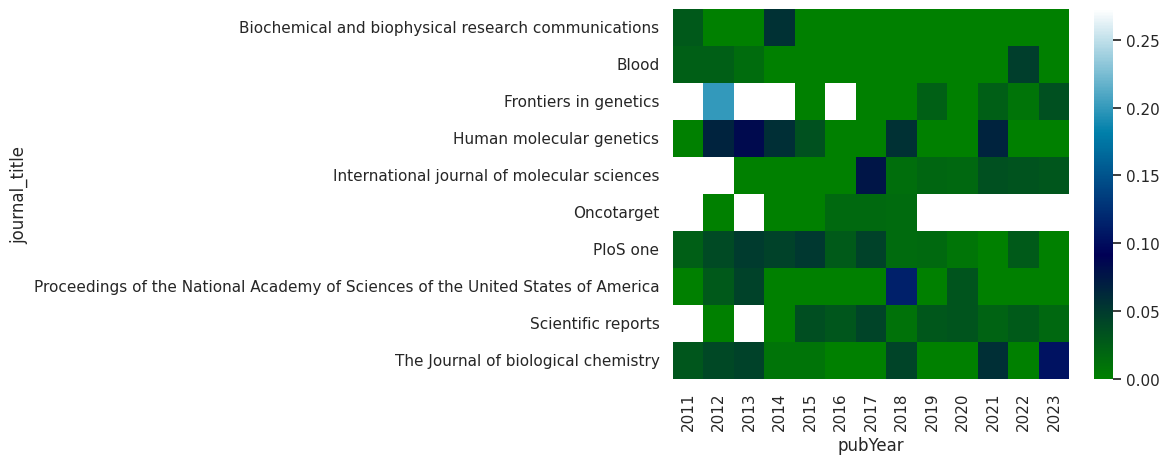

In [19]:
# Pivot the data to create a table with years as columns and journals as rows
sec2pri_filter = sec2pri_all[sec2pri_all['pubYear']>2010]
sec2pri_filter = sec2pri_filter[sec2pri_filter['pmid_primary']>1]
sec2pri_filter = sec2pri_filter[sec2pri_filter['journal_title'].isin(top_10)]
table = sec2pri_filter.pivot_table(index='journal_title', columns='pubYear', values='sec2pri')

# Create the heatmap using seaborn
sns.heatmap(table, cmap='ocean',)

# Show the plot
plt.show()

In [20]:
table.sample(3)

pubYear,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
journal_title,,,,,,,,,,,,,
PloS one,0.024501,0.039205,0.049721,0.044203,0.052081,0.026797,0.043939,0.015152,0.016162,0.00813,0.0,0.026667,0.0
Proceedings of the National Academy of Sciences of the United States of America,0.000000,0.028070,0.043860,0.000000,0.000000,0.000000,0.000000,0.113636,0.000000,0.03125,0.0,0.000000,0.0
Oncotarget,NaN,0.000000,NaN,0.000000,0.000000,0.016912,0.016082,0.015789,NaN,NaN,NaN,NaN,NaN


### 2.3. Mean sec2pri value for gene and year



- Most variable genes

We find the genes for which the `sec2pri` index seems to be the most variable by retrieving the unbiased variance over the `sec2pri` column for each distinct `primarySymbol`:

In [21]:
sec2pri_all['sec2pri_var'] = sec2pri_all.groupby('primarySymbol')['sec2pri'].transform('var')
sec2pri_all['sec2pri_var'].describe()

count    289479.000000
mean          0.006926
std           0.013790
min           0.000000
25%           0.000000
50%           0.000524
75%           0.005996
max           0.091457
Name: sec2pri_var, dtype: float64

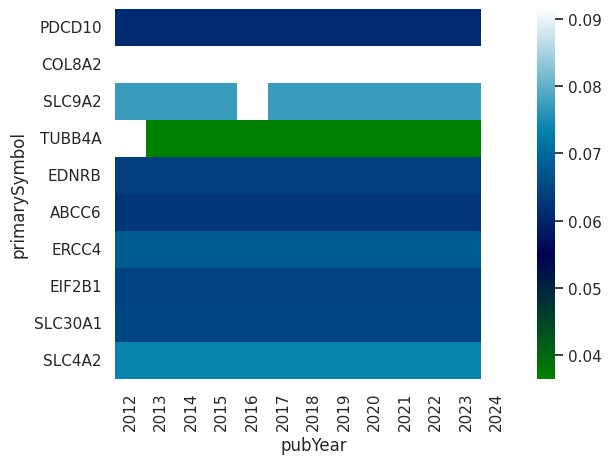

In [22]:
table = sec2pri_all[sec2pri_all['pubYear']>2011].pivot_table(index='primarySymbol', columns='pubYear', values='sec2pri_var')

# Sort the genes by their variance and select the top 100
top_10_genes = table.var(axis=1).sort_values(ascending=False).head(10).index
table_top_10 = table.loc[top_10_genes]

# Create the heatmap using seaborn
sns.heatmap(table_top_10, cmap='ocean')

# Show the plot
plt.show()

## 4. Considering year of approval of the HGNC symbol
We continue the analyses on a subset of symbols for which the year of change (the year the current primary symbol was approved) could be retrieved.

In [23]:
overall_df['year_change'] = pd.to_numeric(overall_df['year_change'], errors='coerce')
subset_df = overall_df.dropna(subset=['year_change'])
subset_df.describe()

,pubYear,pmid,year_change,symbol_code
count,50840.000000,5.084000e+04,50840.000000,50840.000000
mean,2014.751770,2.676717e+07,2006.874489,0.173190
std,7.753365,8.231983e+06,4.105184,0.378416
min,1971.000000,1.320000e+03,2001.000000,0.000000
25%,2011.000000,2.178522e+07,2004.000000,0.000000
50%,2017.000000,2.839575e+07,2006.000000,0.000000
75%,2021.000000,3.350918e+07,2008.000000,0.000000
max,2024.000000,3.775656e+07,2022.000000,1.000000


The first symbol changes took place in 2001. The mean year of change is 2006.9 ± 4.1.
- 2006

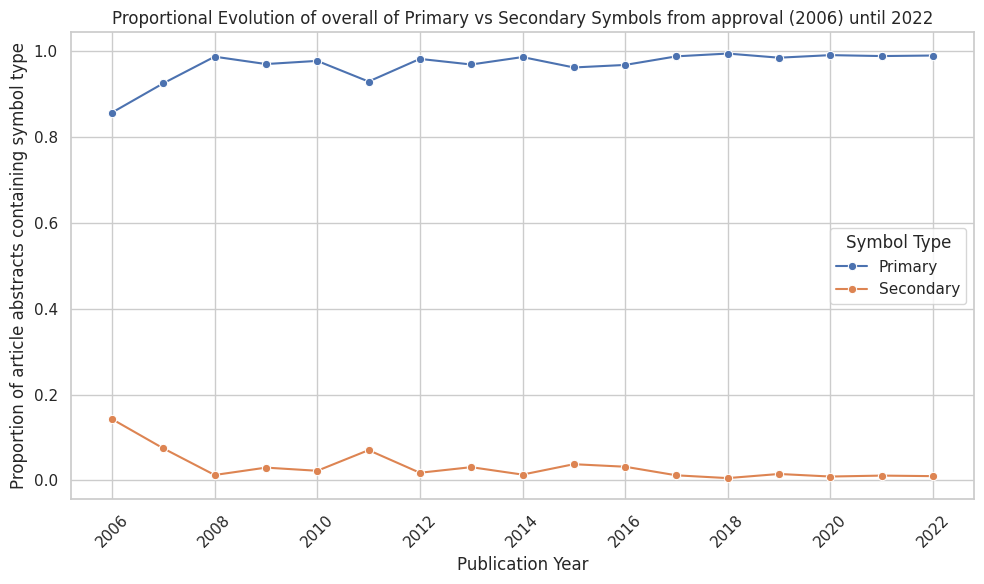

In [24]:
plot_overall_evolution(subset_df[subset_df['year_change'] == 2006], (2006,2022), title='Proportional Evolution of overall of Primary vs Secondary Symbols from approval ({}) until {}')

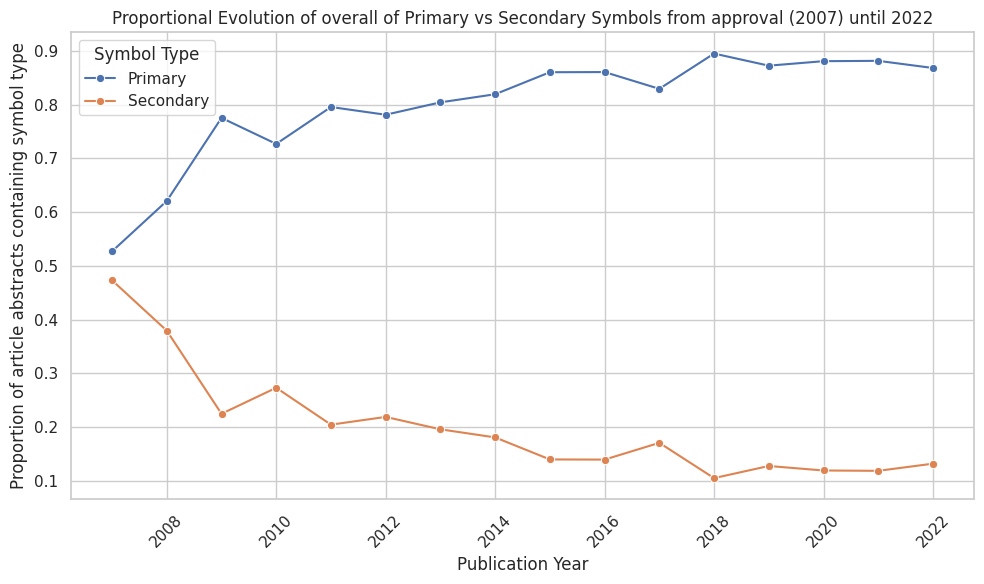

In [25]:
plot_overall_evolution(subset_df[subset_df['year_change'] == 2007], (2007,2022), title='Proportional Evolution of overall of Primary vs Secondary Symbols from approval ({}) until {}')

In [26]:
def plot_primary_evolution(overall_df, year_range=(2000, 2022), title='Proportional Evolution of overall of Primary Symbols ({0}-{1})', year_subset=None):
    try:
        # Filter by year range
        overall_df = overall_df[(overall_df['pubYear'] >= year_range[0]) & (overall_df['pubYear'] <= year_range[1])]

        # Create a count plot
        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")

        # Extract unique 'year_change' values
        unique_year_changes = overall_df['year_change'].unique()

        if year_subset is not None:
            if isinstance(year_subset, range):
                year_subset = list(year_subset)
            # Filter by the specified year subset
            unique_year_changes = [year_change for year_change in unique_year_changes if year_change in year_subset]

        for year_change_value in unique_year_changes:
            subset_df = overall_df[overall_df['year_change'] == year_change_value]

            # Count the number of primary symbols for each year in the subset
            primary_counts = subset_df[subset_df['symbol_type'] == 'primary'].groupby('pubYear').size()
            secondary_counts = subset_df[subset_df['symbol_type'] == 'secondary'].groupby('pubYear').size()

            # Calculate the proportion of primary symbols
            primary_normalized = primary_counts / (primary_counts + secondary_counts)

            # Plot the line for normalized primary symbols
            sns.lineplot(x=primary_normalized.index, y=primary_normalized.values, label=f'Year Change: {year_change_value}')

            # Add a vertical line at the 'year_change'
            plt.axvline(x=year_change_value, color='gray', linestyle='--', linewidth=1, label=f'Year Change: {year_change_value}')

        plt.xlabel('Publication Year')
        plt.ylabel('Proportion of article abstracts containing primary symbols')
        plt.title(title.format(year_range[0], year_range[1]))
        plt.legend(title='Year Change', bbox_to_anchor=(1, 1), loc='upper left')  # Move the legend outside the plot
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Show the plot
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

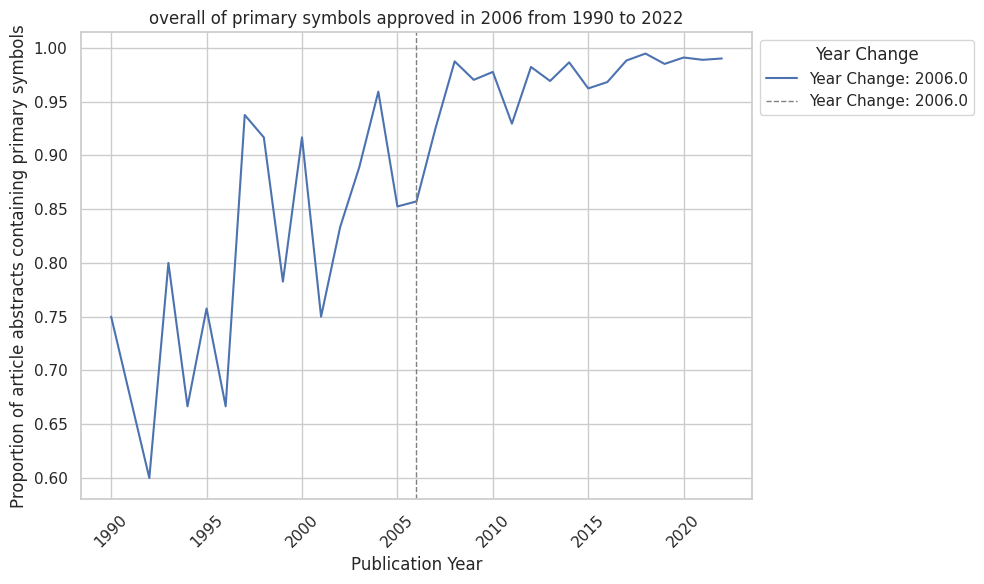

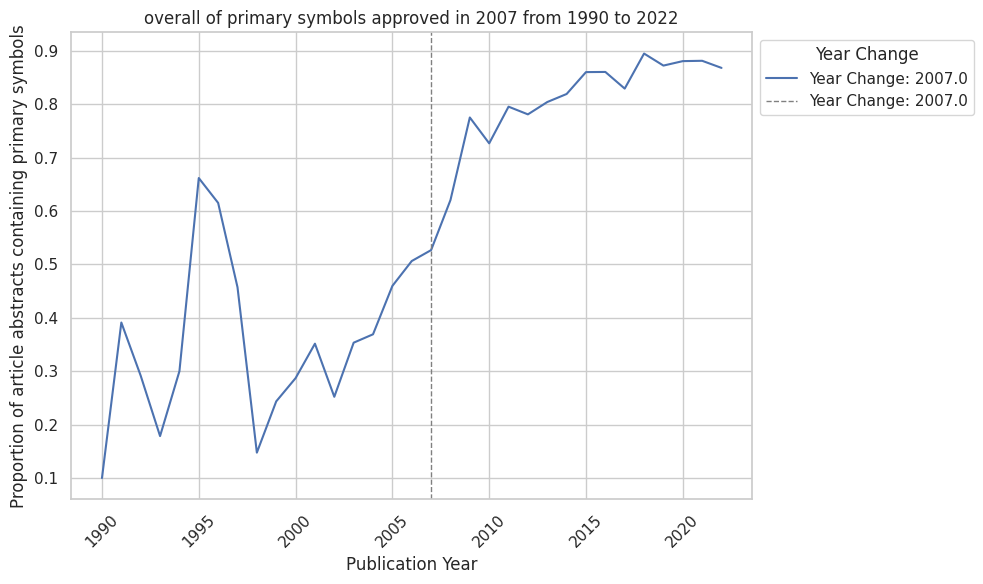

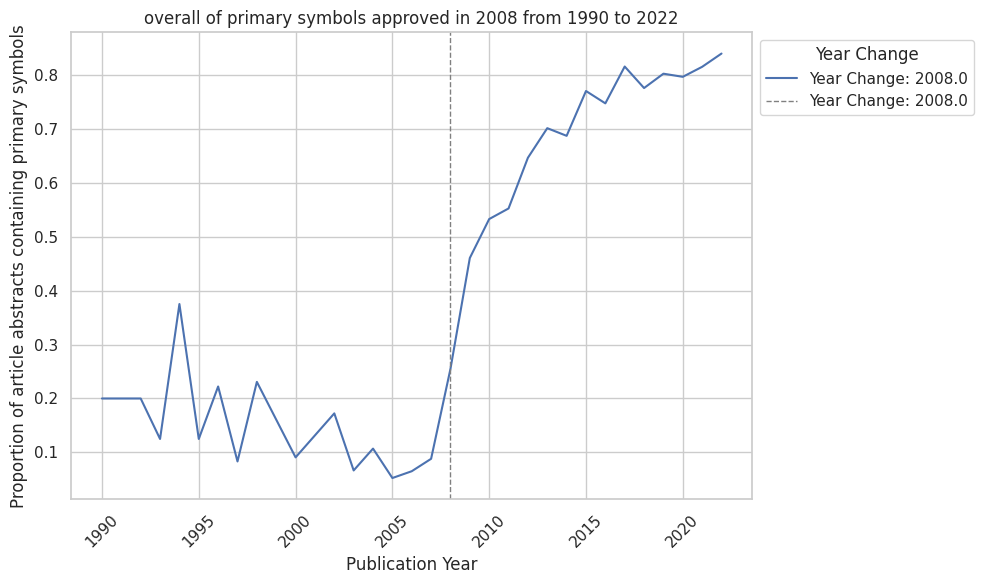

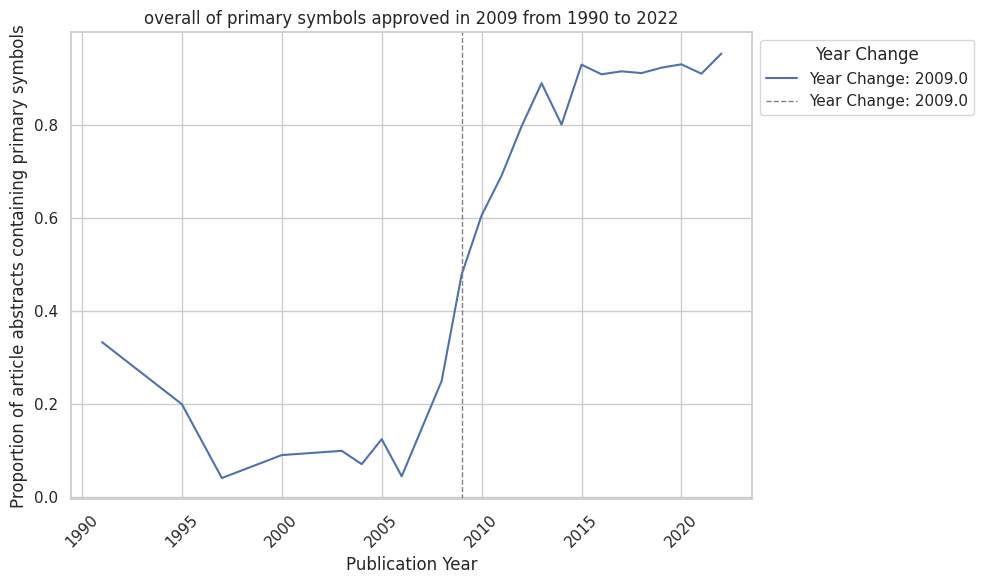

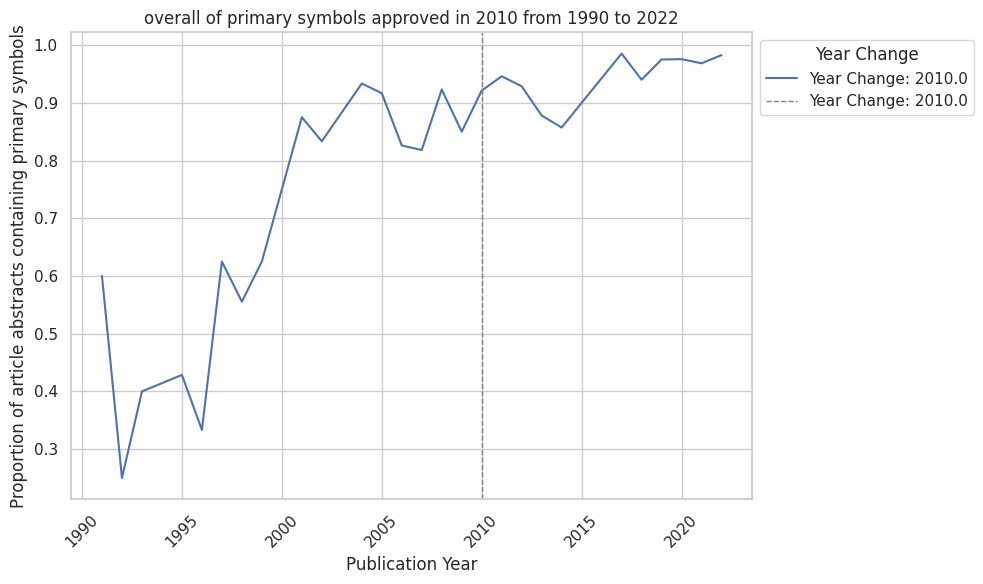

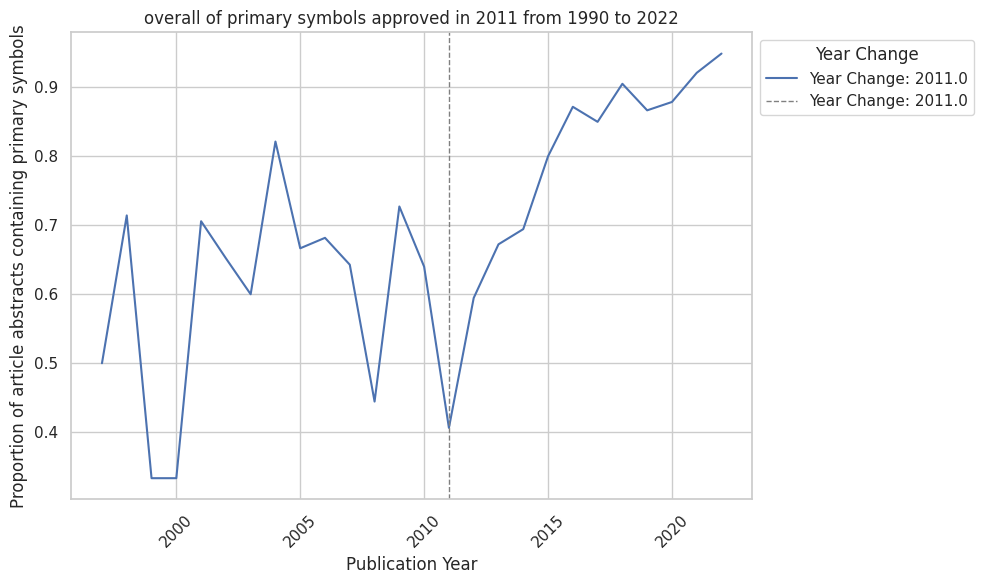

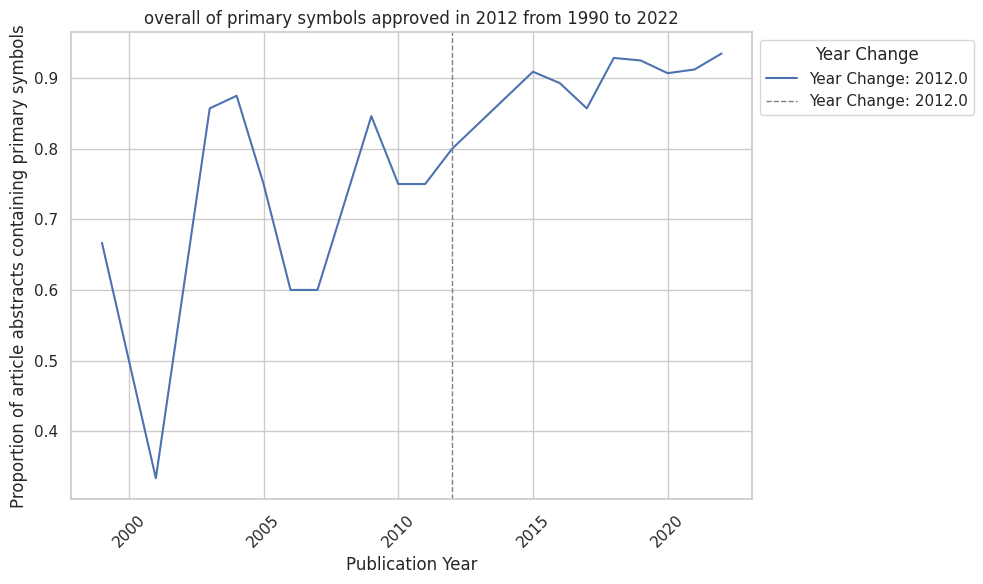

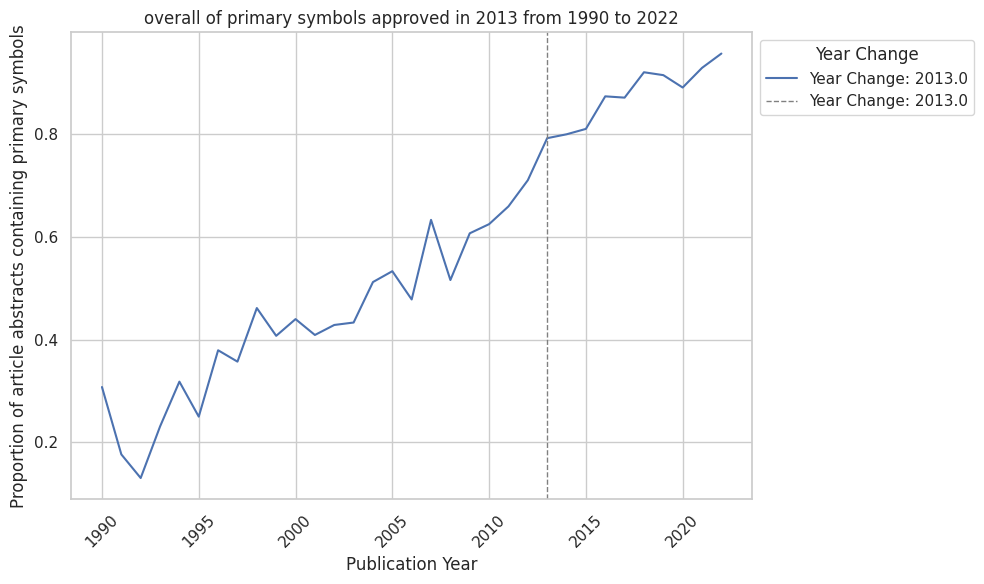

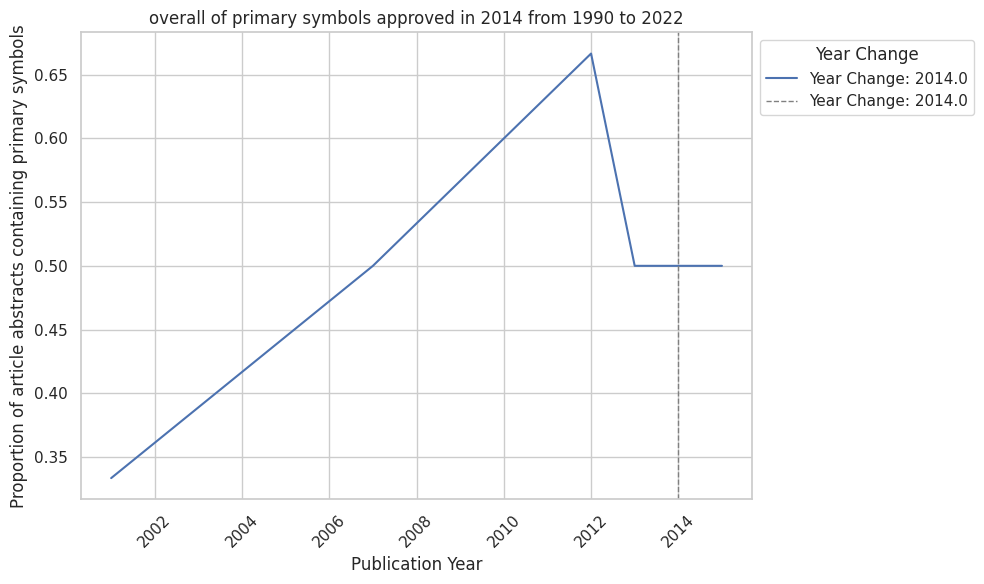

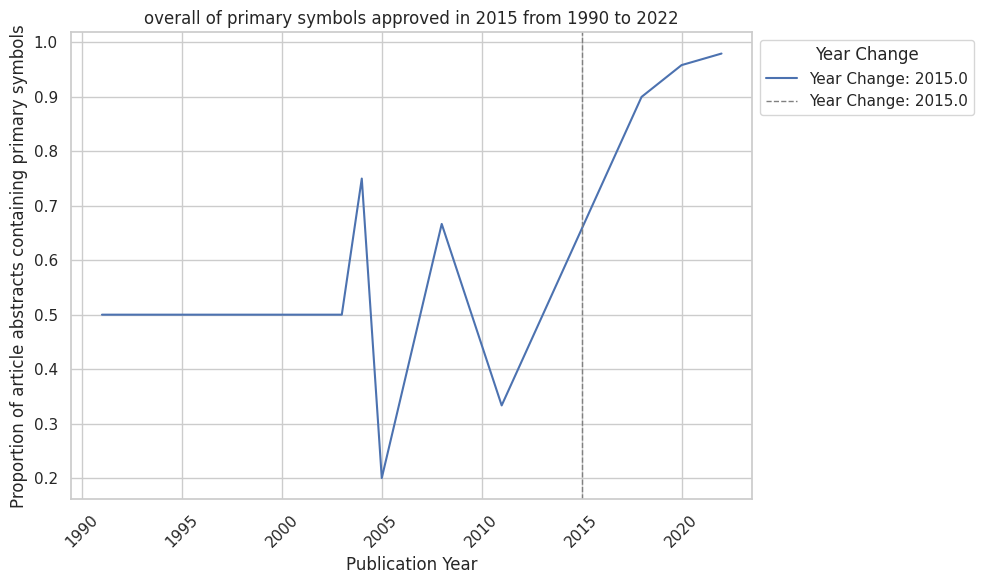

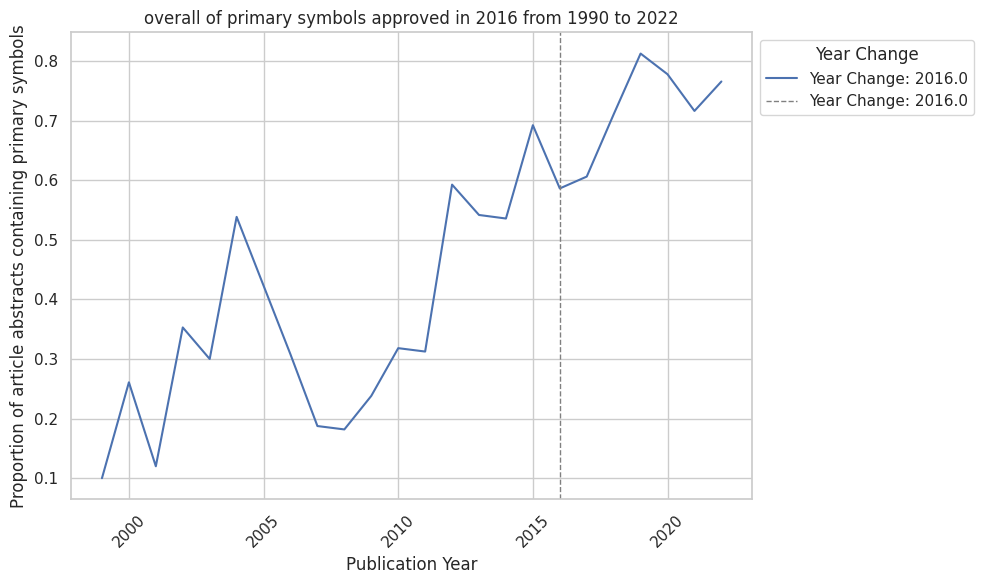

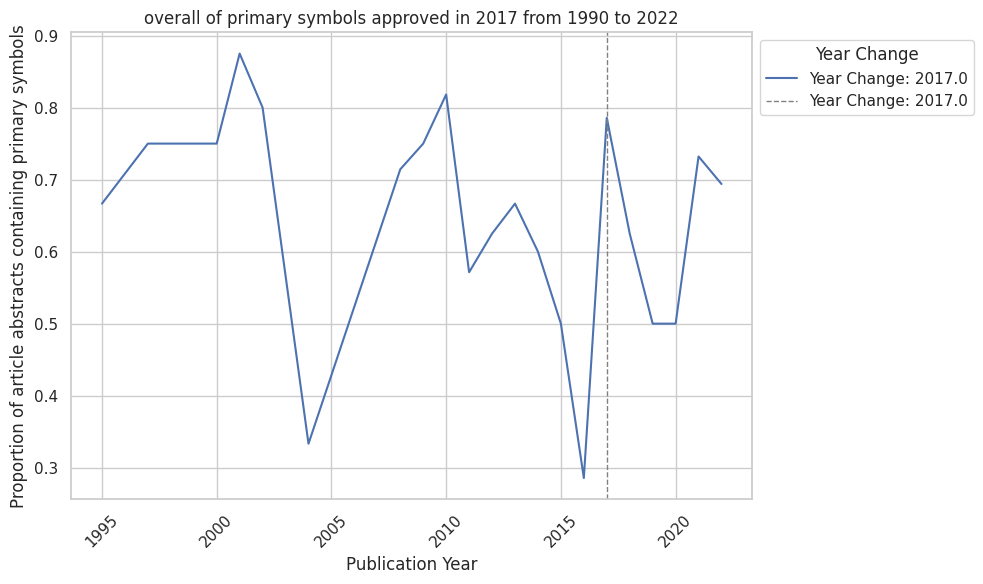

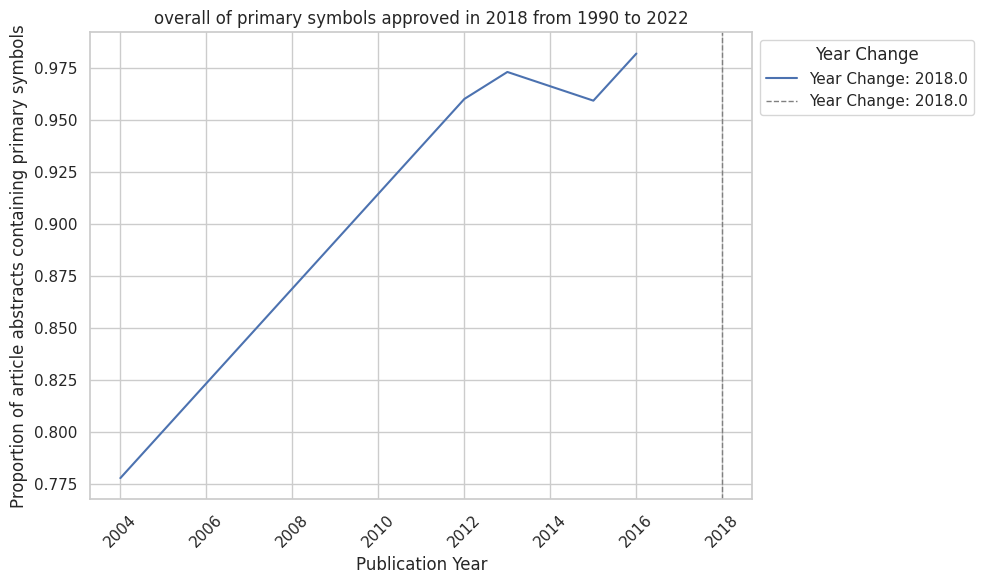

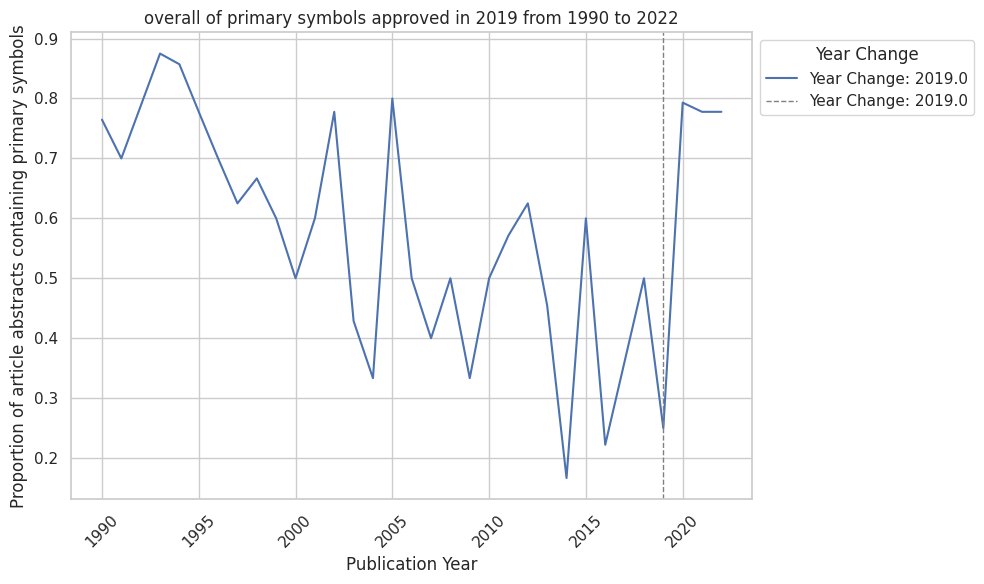

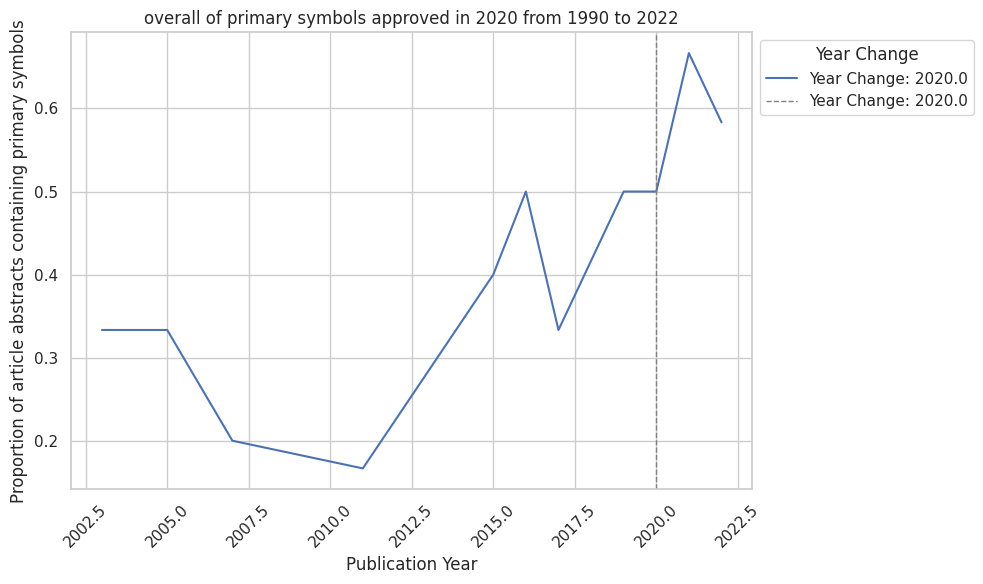

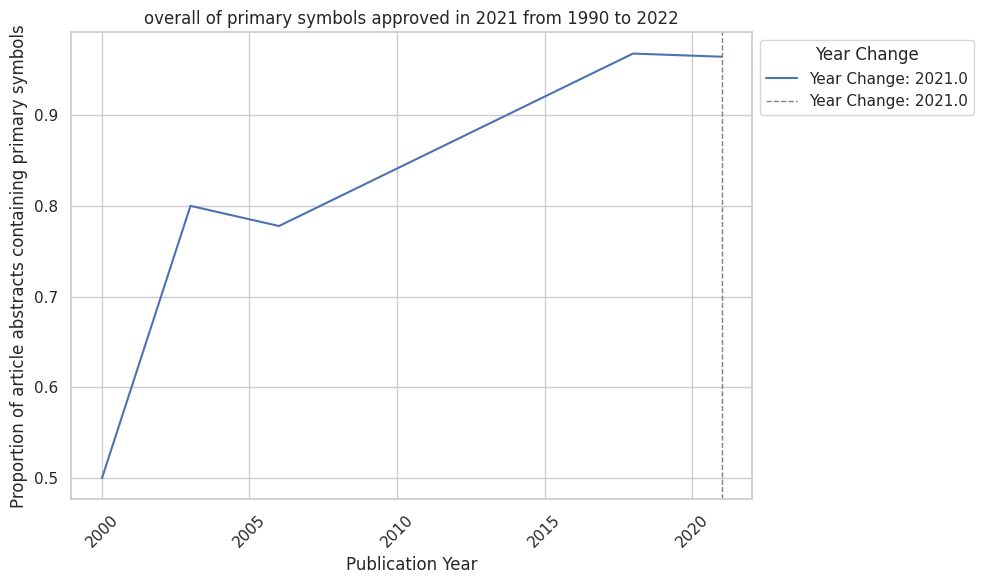

In [27]:
for year in range(2006, 2022):
    plot_primary_evolution(overall_df, (1990, 2022), year_subset=[year], title = f'overall of primary symbols approved in {year} ' + 'from {} to {}')

### overall after approval index
We can define an `overall after approval` index by the formula:

$$ overall_{after} = {a \over b} $$

with:
- `a` = the proportional usage of primaries afer the `year_change`
- `b` = the proportional usage of primaries before the `year_change`

In [35]:
def calculate_adoption_after_approval(overall_df):
    try:
        # Ensure 'pubYear' and 'year_change' are numeric
        overall_df['pubYear'] = pd.to_numeric(overall_df['pubYear'], errors='coerce')
        overall_df['year_change'] = pd.to_numeric(overall_df['year_change'], errors='coerce')

        # Filter out rows with missing or invalid values in 'pubYear' and 'year_change'
        overall_df = overall_df.dropna(subset=['pubYear', 'year_change'])

        # Calculate proportional usage of primaries after year_change
        after_approval = overall_df[overall_df['pubYear'] > overall_df['year_change']]
        primary_counts_after = after_approval[after_approval['symbol_type'] == 'primary'].groupby('pubYear').size()
        primary_normalized_after = primary_counts_after / primary_counts_after.sum()

        # Calculate proportional usage of primaries before year_change
        before_approval = overall_df[overall_df['pubYear'] <= overall_df['year_change']]
        primary_counts_before = before_approval[before_approval['symbol_type'] == 'primary'].groupby('pubYear').size()
        primary_normalized_before = primary_counts_before / primary_counts_before.sum()

        # Merge the two datasets to calculate the adpotion_after_approval index
        overall_df = pd.merge(overall_df, pd.DataFrame(primary_normalized_after, columns=['primary_after']), how='left', left_on='pubYear', right_index=True)
        overall_df = pd.merge(overall_df, pd.DataFrame(primary_normalized_before, columns=['primary_before']), how='left', left_on='pubYear', right_index=True)
        overall_df['adoption_after_approval_index'] = overall_df['primary_after'] / overall_df['primary_before']

        return overall_df

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
subset_df_aaa = calculate_adoption_after_approval(subset_df)


In [36]:
subset_df_aaa.describe()

,pubYear,pmid,year_change,symbol_code,primary_after,primary_before,adoption_after_approval_index
count,50840.000000,5.084000e+04,50840.000000,50840.000000,47108.000000,46869.000000,43137.000000
mean,2014.751770,2.676717e+07,2006.874489,0.173190,0.067889,0.023082,4.076199
std,7.753365,8.231983e+06,4.105184,0.378416,0.035590,0.012051,3.266308
min,1971.000000,1.320000e+03,2001.000000,0.000000,0.000107,0.000212,0.012280
25%,2011.000000,2.178522e+07,2004.000000,0.000000,0.042292,0.015245,1.426752
50%,2017.000000,2.839575e+07,2006.000000,0.000000,0.069415,0.019267,3.439518
75%,2021.000000,3.350918e+07,2008.000000,0.000000,0.098440,0.027737,6.505905
max,2024.000000,3.775656e+07,2022.000000,1.000000,0.121837,0.067965,10.857329


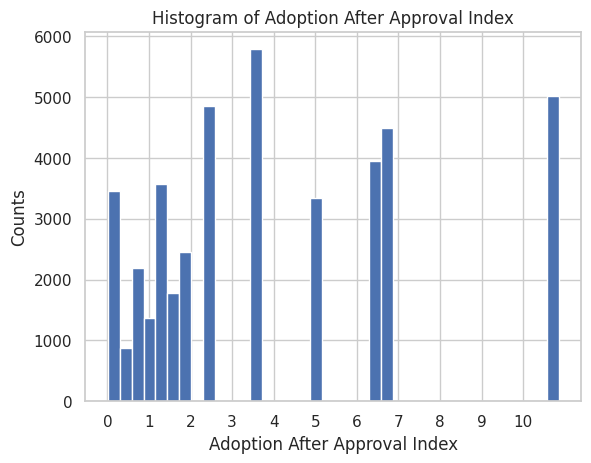

In [41]:
plt.hist(subset_df_aaa['adoption_after_approval_index'], bins='auto')
plt.xticks(range(int(subset_df_aaa['adoption_after_approval_index'].min()), int(subset_df_aaa['adoption_after_approval_index'].max()) + 1))

plt.xlabel('Adoption After Approval Index')
plt.ylabel('Counts')
plt.title('Histogram of Adoption After Approval Index')

plt.show()

In [44]:
worst_aaa = set(subset_df_aaa[subset_df_aaa['adoption_after_approval_index']<1].primarySymbol)
print(f'{len(worst_aaa)} symbols have a `aaa`<1, indicating an incomplete adoption of the primary symbol')

292 symbols have a `aaa`<1, indicating an incomplete adoption of the primary symbol


In [47]:
print("\n".join(worst_aaa))

TPX2
ANO7
G6PC1
WASHC5
EHMT2
B4GALNT1
HDAC8
CISD2
KIF1A
DHX9
CYP2D8P
ATP5F1B
FBXW10
EMILIN3
POLA1
ST8SIA1
FOXG1
SLC37A4
WNK1
TAFAZZIN
MARVELD2
CLIP2
GLE1
HNRNPDL
CFHR1
MED12
CNBP
PIPSL
RAB7A
NECTIN2
KLF6
ZKSCAN3
PRKCB
CD40LG
KHDC1
ST3GAL4
MT1P3
METTL13
MT-TK
NECAB3
EIF1AX
LCE3D
KDM5D
TRAF3IP2
PLEC
CNGA4
LAT2
KDM5C
MT-ND4
CCDC102B
CD82
NKX2-1
CCDC50
PMPCA
ANO5
RAD51B
CCN4
GUCY1B1
MORF4
PROM1
CHMP1A
SP110
ATP6V0C
LRTOMT
DENND1B
KNG1
CD70
TWNK
MED24
RHOB
MED23
SEM1
ANOS1
DCHS1
MT-TT
PPIP5K2
ATXN2
ZKSCAN1
TAF1
BRINP1
PIEZO2
NBPF12
PITPNM3
ELP1
ZKSCAN4
STMN1
FSD1L
SPTLC3
ERLIN2
TSPEAR
STX1B
OSBPL1A
SLC22A18
EPRS1
SLC35C2
DYNC1H1
TMEM185A
GGT7
PRUNE2
HSD17B10
TPSAB1
SLC45A3
ST6GALNAC2
P2RY13
FASLG
XCR1
ZSCAN12
DSTYK
WNK2
ATP5PF
KDM1B
H1-0
GUCY1A1
DEFA1
HGH1
GGCT
PTPN20
ZC4H2
CLRN1
GTF2H5
S1PR3
PSG10P
CCM2
HCAR1
CD93
CNMD
HINT1
SUMO4
TYMP
MT-ATP6
ALDH18A1
SDHAF2
RPL36AL
ABLIM1
FOXN1
TSHZ2
RHOJ
SIGLECL1
NT5C2
TRB
SNRNP70
MED14
KNL1
SERPINA2
TPP1
RIMS1
EYS
PRPH2
ANKS6
ASZ1
THEMIS
RAPH1
UBA1
SLC

## 5. Discussion
### Limitations
- All data were retrieved and generated programatically and there were no manual checks to determine whether a _hit_ for a gene symbol in literature actually corresponds to a gene symbol and not a homograph.It is assumed that all text hits correspond to mentions of gene symbols.
- The `cardinality_1to1` data set is the only one that helps understand the rate of adoption of primary symbols, as it contains for all of its entries both the `year_change` (the year in which the primary symbol became primary) and a one-to-one relationship between primary and secondary identifiers.

### Impact
- The rate at which secondary identifiers are still found in literature published in 2023 (at around 20%) is enough to justify the utility of the `omics fixID` tool.
- Moreover, this rate is consistently lower for older publications dropping at around 50% and below for 20-year old publications. All integration efforts for older literature need to account for this predominance of outdated identifiers